In [3]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
# from nltk.probability import FreqDist
from pathlib import Path
import glob
import random
import pandas as pd
import re
# import requests
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, cross_val_score, RepeatedStratifiedKFold, train_test_split, GridSearchCV
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB,ComplementNB,CategoricalNB
from statistics import mean, stdev
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

In [4]:
def process_file(file_name, file_list, mode = 'lemm'):
    txt_re = re.compile(file_name)
    fname = list(filter(txt_re.search, file_list))[0]
    
    # check file size to make sure the txt file actually has text
    file_size = 0
    while file_size == 0:
        file_size = Path(fname).stat().st_size
        if file_size != 0: # check if conversion to txt didn't work
            with open(fname, 'r') as f:
                text = f.read()
        else:
            print('Empty file, returning None')
            return None
    text_lower = text.lower()
    tokens = word_tokenize(text_lower)
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [t for t in tokens if t not in stop_words]
    
    if mode == 'lemm':
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(t) for t in filtered_tokens]

        return lemmatized_words
    
    elif mode == 'stem':
        stemmer = PorterStemmer()
        stemmed_words = [stemmer.stem(t) for t in filtered_tokens]
    
        return stemmed_words

In [10]:
txt_file_paths = Path('/Users/antonhesse/Desktop/Anton/Education/UMN/Lab and Research/HSPL/CPET_scoping_review/data/cpet_articles/full_texts/txts').glob('*.txt')
gas_clf_df = pd.read_csv('/Users/antonhesse/Desktop/Anton/Education/UMN/Lab and Research/HSPL/CPET_scoping_review/data/cpet_articles/Manual text analysis - Data.csv')
# gas_clf_df['txt_file_name'] = gas_clf_df.apply(lambda x: str(x['Article'] + '.txt'), axis=1)
# gas_clf_df = gas_clf_df[(gas_clf_df['Eligible'] == 'e') & (gas_clf_df['External ref'] == 'n')].reset_index(drop=True)

In [6]:
for idx, row in gas_clf_df.iterrows():
    if row['Eligible'] != 'e':
        row['Gas data'] = 'n'
    if (row['External ref'] == 'y') & (row['Gas data'] != 'y'):
        row['Gas data'] = 'n'

In [16]:
analyzed_txt_files = gas_clf_df['doi_suffix'].to_list()

In [17]:
word_lists = [process_file(f, list(map(str, txt_file_paths)), mode='lemm') for f in tqdm(analyzed_txt_files)]


  0%|          | 0/698 [00:00<?, ?it/s]

IndexError: list index out of range

In [56]:
gas_clf_df['words'] = word_lists
gas_clf_df['avg_word_len'] = gas_clf_df.apply(lambda x: np.mean(list(map(len, x['words']))), axis=1)
gas_clf_df = gas_clf_df[gas_clf_df['avg_word_len'] > 1.5] # removes articles with pdf to txt conversion issue
gas_clf_df[gas_clf_df['Gas data'].isnull()]

,Article,Eligible,Eligibility note,External ref,Gas data,txt_file_name,words,avg_word_len


In [57]:
joined_word_lists = [' '.join(text) for text in gas_clf_df['words']]
gas_data = gas_clf_df['Gas data'].to_list()
counts = gas_clf_df['Gas data'].value_counts()
print(f'Values counts:\n{counts}')
props = round(gas_clf_df['Gas data'].value_counts() / sum(gas_clf_df['Gas data'].value_counts()) * 100,1)
print()
print(f'Proportions:\n{props}')

Values counts:
n    306
y    292
Name: Gas data, dtype: int64

Proportions:
n    51.2
y    48.8
Name: Gas data, dtype: float64


You can use CountVectorizier and TfidfTransformer together, or just use TfidfVectorizer because that combines those steps together. With a Pipeline, however, I'm unsure if you need to separate those two steps or not.

In [58]:
# compare accuracy of different models
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(joined_word_lists)

In [59]:
rskf_cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2)

In [60]:
names = [
#     'MultinomialNB',
#     'BernoulliNB',
#     'GaussianNB',
#     'ComplementNB',
#     'Logistic',
    'RandomForest',
#     'DecisionTree',
#     'KNeighborsClassifier'
#     'SGDClassifier',
#     'SVC',
#     'LinearSVC',
#     'NuSVC'
]

classifiers = [
#     MultinomialNB(),
#     BernoulliNB(),
#     GaussianNB(),
#     ComplementNB(),
#     LogisticRegression(),
    RandomForestClassifier(n_estimators=600),
#     DecisionTreeClassifier(),
#     KNeighborsClassifier(n_neighbors=18),
#     SGDClassifier(),
#     SVC(kernel='linear', degree=3, gamma='auto', probability=True,),
#     LinearSVC(),
#     NuSVC(probability=True)
]

scores_df = pd.DataFrame(columns = names)
scores_df.insert(0, 'Metric', ['Mean', 'Median', 'Min', 'Max', 'SD', 'Comp_time'])

In [37]:
for name, clf in tqdm(zip(names, classifiers), total=len(classifiers)):
    start = time.time()
    clf.fit(X.toarray(), gas_data)
    scores = cross_val_score(clf, X.toarray(), gas_data, cv = rskf_cv)
    end = time.time()
    minutes = round((end - start) // 60,0)
    seconds = round((end - start) % 60,0)
    comp_time = '{minutes}:{seconds}'.format(minutes = minutes, seconds = seconds)
    scores_df[name] = [
        round(np.mean(scores)*100,1),
        round(np.median(scores)*100,1),
        round(min(scores)*100,1),
        round(max(scores)*100,1),
        round(stdev(scores*100),1),
        comp_time
    ]

  0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
scores_df

,Metric,RandomForest
0,Mean,80.8
1,Median,81.0
2,Min,76.7
3,Max,84.3
4,SD,2.8
5,Comp_time,2.0:32.0


In [61]:
folder = Path('/Users/antonhesse/Desktop/Anton/Education/UMN/Lab and Research/HSPL/CPET_scoping_review/data/cpet_articles/pdfs/manual_pdf_analysis/')
manual_analysis_txts = [re.sub('.pdf', '.txt', path.name) for path in folder.rglob('*.pdf')]

In [62]:
def list_intersection(lst1, lst2, output = 'intersection'):
    if output == 'intersection':
        return list(set(lst1).intersection(lst2))
    elif output == 'difference':
        return list(set(lst1).difference(lst2))
    elif output == 'symmetric_difference':
        return list(set(lst1).symmetric_difference(lst2))
    else:
        print('Bad input, returning None')
        return None


In [63]:
test_articles = list_intersection(manual_analysis_txts, analyzed_txt_files, output='difference')
word_lists_test = [process_file(f, txt_files) for f in tqdm(test_articles)]
joined_word_lists_test = [' '.join(text) for text in word_lists_test]

  0%|          | 0/387 [00:00<?, ?it/s]

In [64]:
estimators = [(name, clf) for name, clf in zip(names, classifiers)]
estimators
vote_soft = VotingClassifier(estimators=estimators, voting='soft')
vote_soft.fit(X, gas_data)

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(n_estimators=600))],
                 voting='soft')

In [ ]:
scores = cross_val_score(vote_soft, X, gas_data, cv = rskf_cv)

In [ ]:
print(round(np.mean(scores)*100,1))
print(round(np.median(scores)*100,1))

In [65]:
X_test = vectorizer.transform(joined_word_lists_test)
preds = vote_soft.predict_proba(X_test)

In [66]:
test_dict = {
    'article': test_articles,
    'pred_n': preds[:,0],
    'pred_y': preds[:,1],
    'pred_0.5': abs(preds[:,0]-0.5)
}
test_df = pd.DataFrame.from_dict(test_dict)
test_df['pred'] = test_df.apply(lambda x: 'y' if x['pred_n'] < 0.5 else 'n', axis=1)
test_df['article'] = test_df['article'].apply(lambda x: x.replace('.txt', ''))

In [68]:
# test_df[(test_df['pred'] == 'y') & (test_df['pred_0.5'] < 0.20)].sort_values(by = 'pred_0.5', ascending=True)
# test_df[(test_df['pred'] == 'n') & (test_df['pred_n'] > 0.6)].sort_values(by = 'pred_0.5', ascending=True).iloc[0:20,:]

test_df[test_df['pred_0.5'] < 0.08].sort_values(by = 'pred_0.5', ascending=True).loc[:,['article', 'pred_0.5']]


,article,pred_0.5
106,j.msard.2022.103721,0.008333
198,fendo.2020.531926,0.021667
186,s00421-006-0181-1,0.030000
301,mss.0000000000001204,0.041667
234,s0066-782x2002001200004,0.045000
36,jcm10153299,0.055000
376,22818,0.056667
273,ijerph18063282,0.058333
124,02640414.2021.1876313,0.063333
335,bjsm.11.3.116,0.065000


# Grid searching with random forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(joined_word_lists, gas_data, test_size=0.3, random_state=42)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [40]:
rfc = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [550, 657, 600, 625, 650]
}

In [43]:
GSCV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
GSCV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [550, 657, 600, 625, 650]}, verbose=2)

In [44]:
CV_rfc.best_params_

{'n_estimators': 600}

In [25]:
rfc_best = RandomForestClassifier(n_estimators=CV_rfc.best_params_['n_estimators'], random_state=42)
rfc_best.fit(X_train, y_train)

RandomForestClassifier(n_estimators=600, random_state=42)

In [26]:
pred = rfc_best.predict(X_test)

In [27]:
acc = accuracy_score(y_test, pred)
print("Accuracy for Random Forest on CV data: ", round(acc*100,1))

Accuracy for Random Forest on CV data:  85.5


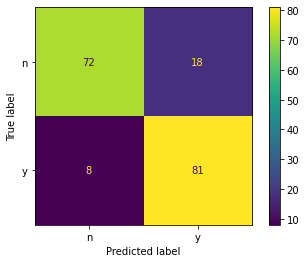

In [29]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_best.classes_)
disp.plot()
plt.show()

# Grid search with SVC

In [46]:
SVC_clf = SVC(random_state=42, probability=True)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, 4, 5],
    'gamma': ['scale', 'auto']
}

In [47]:
GSCV_SVC_clf = GridSearchCV(estimator=SVC_clf,
                              param_grid=param_grid,
                              cv=5, scoring='accuracy',
                              n_jobs=-1,
                              verbose=3)
GSCV_SVC_clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'degree': [3, 4, 5],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [51]:
print(GSCV_SVC_clf.best_params_)
GSCV_SVC_clf_best = SVC(C=10, kernel='sigmoid', degree=3, gamma='scale', random_state=42, probability=True)
GSCV_SVC_clf_best.fit(X_train, y_train)

{'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid'}


SVC(C=10, kernel='sigmoid', probability=True, random_state=42)

In [52]:
pred = GSCV_SVC_clf_best.predict(X_test)
acc = accuracy_score(y_test, pred)
print("Accuracy for SVC on CV data: ", round(acc*100,1))

Accuracy for SVC on CV data:  74.9
